# 15 minutes to QCoDeS

This short introduction is aimed for potential and new users to get the feel of the software. This is a fully functioning Jupyter notebook that will execute simple measurements using dummy instruments. Before you start with your first code using QCoDeS, make sure you have properly set up the Python environment as explained in [this document](../start/index.rst#installation). If you would like to follow this as an interactive notebook, you may [download it from github](https://github.com/QCoDeS/Qcodes/blob/master/docs/examples/15_minutes_to_QCoDeS.ipynb) to run on your local system, or you may use~ the "launch binder" link to use it via a web interface.

## Introduction

QCoDeS is a python-based data acquisition and handling framework to facilitate experiments in nanoelectronics. As highly configurable open source project, we envision that this system may suite the needs of a diverse range of experimental setups, acting as a common system for regular experimental work across the community.

This guide offers a practical overview of QCoDeS, going from installation to experimental data handling in a single notebook. Along the way links are provided to assist you in the configuration of this software's features for your experiments.

## Installation

QCoDeS is readily installed via pip or conda package managers in your preferred environment. These are other installation options are further detailed [in our installation guide](../start/index.rst#installation).

Install via pip:

> pip install qcodes

Install via conda:

> conda -c conda-forge install qcodes

## Module imports

A wide range of modules are available for QCoDeS, but for this example we will only import what is needed for a simple measurement.

In [1]:
import numpy as np
import qcodes as qc
from qcodes.dataset import (
    Measurement,
    experiments,
    initialise_or_create_database_at,
    load_by_run_spec,
    load_or_create_experiment,
)

## Dummy instruments for generating synthetic data
from qcodes.tests.instrument_mocks import (
    DummyInstrument, 
    DummyInstrumentWithMeasurement
)

## Multidimensional scanning module
from qcodes.utils.dataset.doNd import (
    dond, 
    LinSweep
)

## Integrated plotting module
from qcodes.dataset.plotting import plot_dataset

## Using interactive widget
from qcodes.interactive_widget import experiments_widget



## Instruments

`Instrument` class in QCoDeS is responsible for holding connections to hardware and controlling the instruments by its built in methods. For more information on instrument class we refer to the [detailed description here](writing_drivers/Instruments.ipynb)  or the corresponding [api documentation](../api/instrument/index.rst). 

Let us, now, create two dummy instruments: a digital-to-analog converter (`dac`) with two channels, and a digital multimeter (`dmm`) to measure the signals produced: 


In [2]:
# A dummy signal generator with two parameters ch1 and ch2
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])

# A dummy digital multimeter that generates a synthetic data depending
# on the values set on the setter_instr, in this case the dummy dac
dmm = DummyInstrumentWithMeasurement('dmm', setter_instr=dac)

All instruments feature methods to enable you to inspect their configuration. We refer to this as a ``snapshot``. For convenience, methods are provided for a human readable version allowing us to take a glance at our digital multimeter:

In [3]:
dmm.print_readable_snapshot()

dmm:
	parameter value
--------------------------------------------------------------------------------
IDN :	None 
v1  :	0 (V)
v2  :	0 (V)


As we can see here, our dummy multimeter, `dmm`, has two `Parameters` (v1 and v2), that correspond the two channels of our dummy signal generator `dac`. 

## Parameters

A QCoDeS `Parameter` is a value from an instrument that may get and/or set values by methods. Intuitively this is how QCoDeS communicates with most instrumentation, for example a digital multimeter contains settings (e.g. mode, range) and provide data (e.g. voltage, current). These methods are defined by [instrument drivers](index.rst#drivers), that utilize the [parameter API](../api/parameters/index.rst). 

In this example we are using dummy instruments with trivial `set` and `get` methods to generate synthetic data. 

For the `dac`, these settable `Parameters` are added in the instantiation of the `DummyInstrument` class (i.e. `ch1` and `ch2`).


> dac = DummyInstrument('dac', **gates=['ch1', 'ch2']**)


Similarly, the dummy digital multimeter, `dmm`, has gettable `Parameters` added by the instantiation of the `DummyInstrumentWithMeasurement` class defined by the output channels of the setter instrument (i.e. the dac). 


> dmm = DummyInstrumentWithMeasurement('dmm', **setter_instr=dac**)


Instruments may vary in their instantiation (e.g. gates vs. setter_inst), but the `parameters` are the common interface for measurements in QCoDeS. 

For convenience QCoDeS provides a variety of parameter classes built in to accommodate a range of instruments: 

   - `Parameter` : Represents a single value at a given time (e.g. voltage, current), please refer to the [example parameter notebook](Parameters/Parameters.ipynb).
   
   - `ParameterWithSetpoints`: Represents an array of values of all the same type that are returned all at once (e.g. a voltage vs. time waveform). This class is detailed in our [parameter with setpoint notebook](Parameters/Simple-Example-of-ParameterWithSetpoints.ipynb) along with experimental use cases.

   - `DelegateParameter`: It is intended for proxy-ing other parameters and is detailed in the [parameter API](../api/parameters/index.rst). You can use different label, unit, etc in the delegated parameter as compared to the source parameter.

These built in parameter classes are typically used as a wrapper for instrument communications. The user-facing `set` and `get` methods calling instrument facing `set_raw` and `get_raw` methods. Further examples of these parameters are discussed in our example [notebook on Parameters](index.rst#parameters).

### Example of setting and getting parameters

In most cases, a settable parameter accepts its value as an argument of a simple function call. For our example, we will set the a value of 1.1 for the `ch1` parameter of our signal generator, `dac`, by providing the value to the instrument channel:

In [4]:
dac.ch1(1.1)

Similarly, a gettable parameter will often return its value with a simple function call. In our example, we will read the value of our digital multimeter, `dmm`, like so:

In [5]:
dmm.v1()

4.140902899174545

## Stations  

A station is a collection of all the instruments and devices present in your experiment. As mentioned earlier, it can be thought of as a bucket where you can add your `Instruments`, `Parameters` and other components. Each of these terms has a definite meaning in QCoDeS and shall be explained in later sections. Once a station is properly configured, you can use its instances to access these components. We refer to tutorial on [Station](Station.ipynb) for more details.

To organize our dummy instruments, we will first instantiate a station as so:

In [6]:
station = qc.Station()

### Adding instruments to the station

Every instrument that you are working with during an experiment should be added to a `Station`.  

Here, we add the `dac` and `dmm` instruments by using our station's `add_component()` method: 

In [7]:
station.add_component(dac)
station.add_component(dmm)

'dmm'

### Inspecting the station

For any experiment it is essential to have a record of the instrumental setup. To enable this, a `Station` has a `snapshot` method which provides a dictionary of its `Instruments` and their properties (e.g. `Parameters`) in a recursive manner.

This data is typically saved with every experiment run with QCoDeS, but the `snapshot` method may be used on a station to inspect its status:


In [8]:
# Remove the ``_ = `` part to see the full snapshot
_ = station.snapshot()

This generates a lengthy output. While we will truncate it for this tutorial, the nested dictionaries offer a human- and machine-readable description of the station and its attached instruments:

```
{'instruments': {'dmm': {'functions': {},
   'submodules': {},
   '__class__': 'qcodes.tests.instrument_mocks.DummyInstrumentWithMeasurement',
   'parameters': {'IDN': {'__class__': 'qcodes.instrument.parameter.Parameter',
    [...]
     'inter_delay': 0,
     'instrument': 'qcodes.tests.instrument_mocks.DummyInstrumentWithMeasurement',
     'instrument_name': 'dmm',
     'unit': ''},
    'v1': {'__class__': 'qcodes.tests.instrument_mocks.DmmExponentialParameter',
     'full_name': 'dmm_v1',
     'value': 5.136319425854842,
     'raw_value': 5.136319425854842,
     'ts': '2021-03-29 18:47:16',
     'label': 'Gate v1',
     'name': 'v1',
     'post_delay': 0,
     'vals': '<Numbers -800<=v<=400>',
     'inter_delay': 0,
     'instrument': 'qcodes.tests.instrument_mocks.DummyInstrumentWithMeasurement',
     'instrument_name': 'dmm',
     'unit': 'V'},
     [...]
```

### Saving and loading configurations.

The instantiation of the instruments, that is, setting up the proper initial values of the corresponding parameters and similar pre-specifications of a measurement constitutes the initialization portion of the code. In general, this portion can be quite long and tedious to maintain. These (and more) concerns can be solved by a [YAML configuration file](Station.ipynb#Using-Station-with-YAML-configuration-files) of the `Station` object. Further options for stations are detailed in the [station example](Station.ipynb#Default-Station).


## Databases and experiments.

With `Station` a working station, the next step is to set up a `database` in order to save our data to. In QCoDeS, we implement a SQLite3 database for this purpose. 

### Initialize or create a database

Before starting a measurement, we first initialize a database. The location of the database is specified by the configuration object of the QCoDeS installation. The database is created with the latest supported version complying with the QCoDeS version that is currently under use. If a database already exists but an upgrade has been done to the QCoDeS, then that database can continue to be used and it is going to be upgraded to the latest version automatically at first connection.

The initialization (or creation) of the database at a particular location is achieved via static function:

In [9]:
initialise_or_create_database_at("~/experiments_for_15_mins.db")

By default, QCoDeS only supports a single active database. The current database location is stored in the configuration data (i.e. qcodes.config). 

In [10]:
qc.config.core.db_location

'~/experiments_for_15_mins.db'

### Load or create an experiment

After initializing the database we create an `Experiment` object. This object contains the names of the experiment and sample, and acts as a manager for data acquired during measurement. The `load_or_create_experiment` function will return an existing experiment with the same name, but if no experiments are found, it will create a new one.

For this example, we will call our experiment `tutorial_exp`:


In [11]:
tutorial_exp = load_or_create_experiment(
    experiment_name="tutorial_exp",
    sample_name="synthetic data"
)

The path of the database for the `experiment` is the defined path in the QCoDeS configuration. First, `Experiment` loads the database in that path (or it creates one if there is no database in that path), and then saves the created experiment in that database. If an experiment with this name and sample name already exists this will be set as the default experiment for the rest of the session. Although loading or creating a database with the experiment is a user-friendly feature, we recommend users to initialize their database as shown earlier. This practice allows better control of the experiments and databases for measurements, avoiding unexpected outcomes in data management.

The method shown above to load or create the experiment is the most versatile one. However there are other options discussed in the guide on databases.

## Measurement Context Manager

The `Measurement` object is used to obtain data from instruments in QCoDeS, as such it is instantiated with both an `experiment` (to handle data) and `station` to control the instruments. If these arguments are absent, the most recent experiment and station are used as defaults. A keyword argument `name` can also be set as any string value, this string will be used to identify the resulting dataset. 

In [12]:
context_meas = Measurement(exp=tutorial_exp, station=station, name='context_example')

It is possible to instantiate a `measurement` prior to creating or loading an experiment, but this is not advisable.

1. If the initialized `database` does not contain an `experiment`, then the instantiation will raise an error and halt your work.
2. If the database already contains an `experiment`, then the instantiated `measurement`  will be added to the most recent `experiment` in the database without raising an error message or warning. This will lead to poor data management.


### Registering parameters to measure

QCoDeS features the ability to store the relationship between parameters (i.e. parameter `y` is dependent on `x`). This feature allows the intent of the measurement to be clearly recorded in the experimental records. In addition, the parameter dependency is used to define the coordinate axes when plotting the data using QCoDeS. The parameters which are being measured are first registered with the `measurement`. When registering a dependent parameter (i.e. y(x)) the independent parameter is declared as a setpoint. As a consequence, independent parameters must be registered prior to their corresponding dependent parameters. 

In our example, ``dac.ch1`` is the independent parameter and ``dmm.v1`` is the dependent parameter. So we register ``dmm.v1`` with the setpoint as ``dac.ch1``. 

In [13]:
# Register the independent parameter...
context_meas.register_parameter(dac.ch1)
# ...then register the dependent parameter
context_meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))

### Example measurement loop

The QCoDeS measurement module provides a context manager for registering parameters to measure and store results. Within the context manager, measured data is periodically saved to the database as a background process.

To conduct a simple measurement, we can create a simple loop inside the context manager which will control the instruments, acquire data, and store the results. 

> This is the a more user-configurable approach for acquiring data in QCoDeS. For more examples and details, refer to [Performing measurements using QCoDeS parameters and DataSet example](./DataSet/Performing-measurements-using-qcodes-parameters-and-dataset.ipynb)


In [14]:
# Time for periodic background database writes
context_meas.write_period = 2

with context_meas.run() as datasaver:
    for set_v in np.linspace(0, 25, 10):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()
        datasaver.add_result((dac.ch1, set_v),
                             (dmm.v1, get_v))

    # Convenient to have for plotting and data access
    dataset = datasaver.dataset

Starting experimental run with id: 1. 


The `meas.run` method returns a context manager to control data acquisition and storage. Entering the context provides a `DataSaver` object, which we will store as the `datasaver` variable. Using a simple loop structure, we can use instruments' `set` and `get` methods to control the instrument and acquire data respectively. Then, we use the ``add_result`` method to validate the size of all the data points and store them intermittently into a write cache. Within every write-period of the measurement, the data of this cache is flushed to the database in the background.

## Using the doNd multi-dimensional measurement utility 

Qcodes also includes functions to produce multidimensional data sets with [optimized data handling](DataSet/Using_doNd_functions_in_comparison_to_Measurement_context_manager_for_performing_measurements.ipynb); of these, ``dond`` (i.e. do n-dimensional facilitates collecting multidimensional data.  Similar optimizations can be made using the measurement context (see [measuring with shaped data](DataSet/Performing-measurements-using-qcodes-parameters-and-dataset.ipynb#Specifying-shape-of-measurement)), but this approach simplifies the setup and readability of the code. 

> This is a more user-friendly way of acquiring multi-dimensional data in QCoDeS.

We will first set up the measurement by defining the sweeps for each independent parameters, in our case the two channels of ``dac``:

In [15]:
# Setting up a doNd measurement
sweep_1 = LinSweep(dac.ch1, -1, 1, 20, 0.01)
sweep_2 = LinSweep(dac.ch2, -1, 1, 20, 0.01)


This linear sweeps for `dac.ch1` and `dac.ch2` are defined by the endpoints of the sweep (-1 to 1 V), the number of steps (20) and a time delay between each step (0.01 s). This delay time is used to allow real instruments to equilibrate between each step in the sweep. Multiple types of sweeps are [included with QCoDeS](DataSet/Using_doNd_functions_in_comparison_to_Measurement_context_manager_for_performing_measurements.ipynb) to enable a variety of sampling schemes. 

> When using `dond` we do not register parameters, this is done automatically by the function. With dond every dependent parameter depends on all sweep parameters.

In [16]:
dond(
    sweep_1,                          # 1st independent parameter
    sweep_2,                          # 2nd independent parameter
    dmm.v1,                           # 1st dependent parameter
    dmm.v2,                           # 2nd dependent parameter
    measurement_name="dond_example",  # Set the measurement name
    exp=tutorial_exp,                 # Set the experiment to save data to.
    show_progress=True                # Optional progress bar
)


Starting experimental run with id: 2. Using 'qcodes.dataset.dond'


  0%|          | 0/400 [00:00<?, ?it/s]

(dond_example #2@/home/runner/experiments_for_15_mins.db
 -------------------------------------------------------
 dac_ch1 - numeric
 dac_ch2 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 (None,),
 (None,))

The ``dond`` function features a number of options (e.g. plotting, database write period, multithreading) which are further detailed in our [example notebooks](DataSet/Using_doNd_functions_in_comparison_to_Measurement_context_manager_for_performing_measurements.ipynb#Handling-plot,-experiment,-and-measurement_name-with-doNd). For simple measurements, [do1d](DataSet/Using_doNd_functions_in_comparison_to_Measurement_context_manager_for_performing_measurements.ipynb#do1d) and [do2d](DataSet/Using_doNd_functions_in_comparison_to_Measurement_context_manager_for_performing_measurements.ipynb#do2d) provide a simpler interface with similar functionality for 1d and 2d acquisitions.

## Exploring datasets and databases

In this section we detail methods and functions for working with `DataSets`. In QCoDeS, all measured results are generally packaged and stored in the database as a `DataSet` object. While it isn't essential for running QCoDeS, we provide a [detailed walktrough notebook](DataSet/DataSet-class-walkthrough.ipynb) to assist users in developing new data analysis methods.

### List all datasets in a database.

The most direct way of finding our data is the `experiments` function; this queries the currently initialized `database` and prints the `experiments` and `datasets` contained inside. 

In [17]:
experiments()

[tutorial_exp#synthetic data#1@/home/runner/experiments_for_15_mins.db
 ---------------------------------------------------------------------
 1-context_example-1-dac_ch1,dmm_v1-10
 2-dond_example-2-dac_ch1,dac_ch2,dmm_v1,dmm_v2-800]

While this example database contains only a few experiments this number may grow significantly as you perform measurements on your nanoelectronic devices. 

While our example database contains only few experiments, in reality the database will contain several experiments containing many datasets. Often, you would like to load a dataset from a particular experiment for further analysis. Here we shall explore different ways to find and retrieve already measured dataset from the database.

### List all the datasets in an experiment

An experiment also contains the `datasets` produced by its `measurements`. Using the `data_sets` method we can print a list of these `datasets`, the parameters recorded, and the type of data obtained for each parameter.

In [18]:
tutorial_exp.data_sets()

[context_example #1@/home/runner/experiments_for_15_mins.db
 ----------------------------------------------------------
 dac_ch1 - numeric
 dmm_v1 - numeric,
 dond_example #2@/home/runner/experiments_for_15_mins.db
 -------------------------------------------------------
 dac_ch1 - numeric
 dac_ch2 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric]

### Load the data set using one or more specifications

In order to plot or analyze data, we will need to retrieve the `datasets`. While this can be done directly from the `experiment`, instrument environments are typically not used for analysis. Moreover, we may wish to compare data from separate `experiments` requiring us to load datasets separately.

In QCoDeS, `datasets` can be obtained using simple criteria via the  `load_by_run_spec` function. For this example we will load our previous 1d and 2d datasets by their name and database id number: 

In [19]:
dataset_1d = load_by_run_spec(experiment_name='tutorial_exp', captured_run_id=1)
dataset_2d = load_by_run_spec(experiment_name='tutorial_exp', captured_run_id=2)

While the arguments are optional, the function call will raise an error if more than one run matching the supplied specifications is found. If such an error occurs, the traceback will contain the specifications of the runs, as well. More examples of refined search criteria for data extraction are provided in [this example notebook](DataSet/Extracting-runs-from-one-DB-file-to-another.ipynb#Uniquely-identifying-and-loading-runs).


### Plotting datasets

Numerical data is typically difficult to understand when tabulated, so we would want to visualize it as a plot. QCoDeS includes an integrated plotting function, `plot_dataset`, that neatly visualizes our 1d and 2d `datasets`:

Trying to mark a run completed that was already completed.


([<AxesSubplot: title={'center': 'Run #1, Experiment tutorial_exp (synthetic data)'}, xlabel='Gate ch1 (V)', ylabel='Gate v1 (V)'>],
 [None])

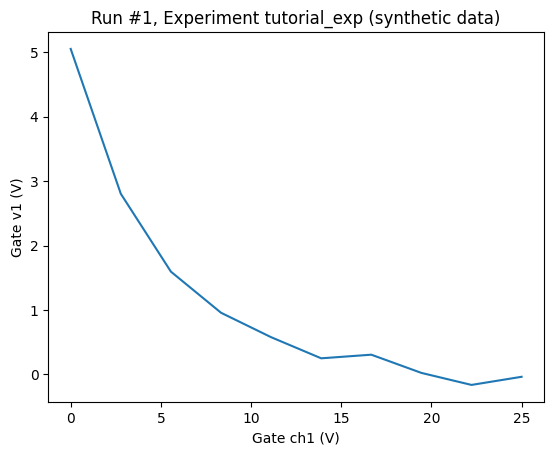

In [20]:
# Plotting 1d dataset
plot_dataset(dataset_1d)

With 1d data a simple line plot will be generated with the dependent and independent parameters set to the respective X and Y axes. This works nicely because of the integration of the `instrument` (providing units) and the predefined dependency between `parameters` measured.

Trying to mark a run completed that was already completed.


([<AxesSubplot: title={'center': 'Run #2, Experiment tutorial_exp (synthetic data)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>,
  <AxesSubplot: title={'center': 'Run #2, Experiment tutorial_exp (synthetic data)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>],
  <matplotlib.colorbar.Colorbar at 0x7efda5c57730>])

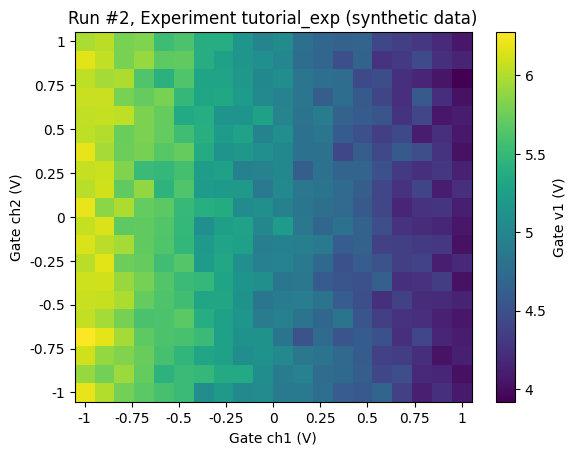

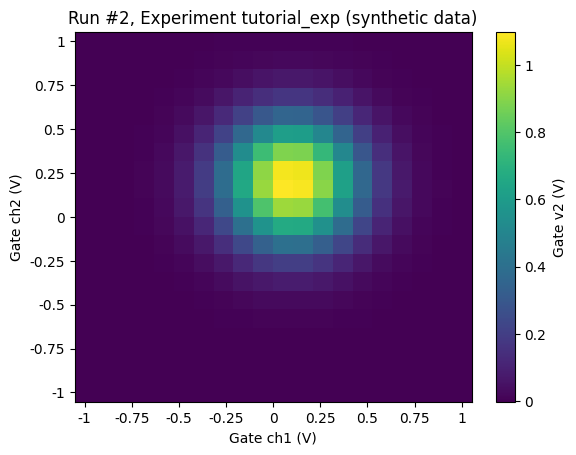

In [21]:
# Plotting 2d dataset as heatmaps
plot_dataset(dataset_2d)


With 2d data heat maps will be generated with the independent parameters set to the X and Y axes and the dependent parameter set as the color scale. Similar to the 1d case, this automatic visualization depends on the predefined `parameters` provided to the `dond` function. 

>For more detailed examples of plotting QCoDeS datasets, we have articles covering a variety of data types:
>
> - [Offline plotting tutorial](DataSet/Offline%20Plotting%20Tutorial.ipynb)
> - [Offline plotting with categorical data](DataSet/Offline%20plotting%20with%20categorical%20data.ipynb)
> - [Offline plotting with complex data](DataSet/Offline%20plotting%20with%20complex%20data.ipynb)

### QCoDeS measurements live plotting with Plottr

Plottr supports and is recommended for live plotting QCoDeS measurements. This enables a direct visualization of an ongoing measurement to facilitate experimentalists. [How to use plottr with QCoDeS for live plotting](plotting/How-to-use-Plottr-with-QCoDeS-for-live-plotting.ipynb) notebook contains more information.

### Get data of specific parameter of a dataset

When designing a new analysis method for your nanoelectronic measurements, it may be useful to extract the data from an individual parameter obtained in a dataset. Using the `get_parameter_data` method included in `DataSet` we obtain a dictionary of the data for a single parameter.

> Note that this method behaves differently for independent (e.g. `dac_ch1`) or dependent (e.g. `dmm_v1`) parameters:

In [22]:
# All data for all parameters
dataset_1d.get_parameter_data()

{'dmm_v1': {'dmm_v1': array([ 5.05155824,  2.80357773,  1.59485828,  0.9569754 ,  0.57754714,
          0.2496897 ,  0.30582185,  0.02317228, -0.1633544 , -0.03718256]),
  'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

In [23]:
# Data for independent parameter
dataset_1d.get_parameter_data('dac_ch1')

{'dac_ch1': {'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

In [24]:
# Data for dependent parameter
dataset_1d.get_parameter_data('dmm_v1')

{'dmm_v1': {'dmm_v1': array([ 5.05155824,  2.80357773,  1.59485828,  0.9569754 ,  0.57754714,
          0.2496897 ,  0.30582185,  0.02317228, -0.1633544 , -0.03718256]),
  'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

We refer reader to [exporting data section of the performing measurements using QCoDeS parameters and dataset](DataSet/Performing-measurements-using-qcodes-parameters-and-dataset.ipynb#Accessing-and-exporting-the-measured-data) and [Accessing data in DataSet notebook](DataSet/Accessing-data-in-DataSet.ipynb) for further information on `get_parameter_data` method.

### Export data to pandas dataframe

Similarly, data stored within a QCoDeS database may be exported as pandas dataframes for analysis. This is accomplished by the `to_pandas_dataframe` method included in `DataSet`.

In [25]:
df = dataset_1d.to_pandas_dataframe()
df.head()

,dmm_v1
dac_ch1,
0.000000,5.051558
2.777778,2.803578
5.555556,1.594858
8.333333,0.956975
11.111111,0.577547


### Export data to xarray

It's also possible to export data stored within a QCoDeS `dataset` to an `xarray.DataSet`. This can be achieved as so:

In [26]:
xr_dataset = dataset_1d.to_xarray_dataset()
xr_dataset

<xarray.Dataset>
Dimensions:  (dac_ch1: 10)
Coordinates:
  * dac_ch1  (dac_ch1) float64 0.0 2.778 5.556 8.333 ... 16.67 19.44 22.22 25.0
Data variables:
    dmm_v1   (dac_ch1) float64 5.052 2.804 1.595 ... 0.02317 -0.1634 -0.03718
Attributes: (12/14)
    ds_name:                  context_example
    sample_name:              synthetic data
    exp_name:                 tutorial_exp
    snapshot:                 {"station": {"instruments": {"dac": {"functions...
    guid:                     aaaaaaaa-0000-0000-0000-01857d68a623
    run_timestamp:            2023-01-04 15:31:28
    ...                       ...
    captured_counter:         1
    run_id:                   1
    run_description:          {"version": 3, "interdependencies": {"paramspec...
    parent_dataset_links:     []
    run_timestamp_raw:        1672846288.424675
    completed_timestamp_raw:  1672846288.4283977

We refer to [example notebook on working with pandas](DataSet/Working-With-Pandas-and-XArray.ipynb) and [Accessing data in DataSet notebook](DataSet/Accessing-data-in-DataSet.ipynb) for further information.

### Explore the data using an interactive widget

Going beyond text-based review, we have also included a graphical widget to allow the easy exploration of our databases, with an interface for viewing the station snapshot, adding notes, or producing plots of the selected day.  

> This widget uses [ipywidgets](https://ipywidgets.readthedocs.io/) to display an interactive elements and is only available when run in a Jupyter notebook. However, we do provide a quick, non-interactive demonstration video below as well.

Here we will load our example database that we initialized earlier.

In [27]:
experiments_widget(sort_by="timestamp")

Here's a short video that summarizes the looks and the features:

![video demo about experiments widget should show here](../_static/experiments_widget.webp)

## Further Reading

### QCoDeS configuration  

QCoDeS uses a JSON based configuration system. It is shipped with a default configuration. The default config file should not be overwritten. If you have any modifications, you should save the updated config file on your home directory or in the current working directory of your script/notebook. The QCoDeS config system first looks in the current directory for a config file and then in the home directory for one and only then - if no config files are found - it falls back to using the default one. The default config is located in `qcodes.config`. To know how to change and save the config please refer to the [documentation on config](Configuring_QCoDeS.ipynb).

### QCoDeS instrument drivers
We support and provide drivers for most of the instruments currently in use at the Microsoft stations. However, if more functionalities than the ones which are currently supported by drivers are required, one may update the driver or request the features form QCoDeS team. You are more than welcome to contribute and if you would like to have a quick overview on how to write instrument drivers, please refer to the [this notebook](writing_drivers/Instruments.ipynb) as well as the other [example notebooks on writing drivers](index.rst#writing-drivers).

### QCoDeS logging

In every measurement session, it is highly recommended to have QCoDeS logging turned on. This will allow you to have all the logs in case troubleshooting is required. This feature is detailed further in an [example notebook](logging/logging_example.ipynb) that describes all the logging features.